Make some plots of our first three models to see if we can come up with any conclusionns..

In this notebook we want to do the following:
- Load trained XGBoost models
- Plot and visualise trained models
- See what we can find from our trained models

We have 3 separate XGBoost models, trained on 9 features out of a totall of 27 features each.

Following this, we want to train a linear regression model on top of this. The plan for now is a very basic, train a stacked model on XGBoost predictions.

Author: Steven Vuong
Date: 26/04/2020

In [1]:
# Mount google drive (working in a google-colab notebook)
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# cd into correct working directory
% cd '../gdrive/My Drive/self_teach/udacity_ml_eng_nanodegree'

/gdrive/My Drive/self_teach/udacity_ml_eng_nanodegree


In [3]:
# Import necessary libraries as usual
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import warnings
import pickle
import numpy as np

from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline
# Styling Preferences
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We will define some plot functions that will help us visualise and evaluate the performance of our model. As well as take a look at what our model is prioritising.

In [0]:
def plot_features(booster, figsize): 
    """Plot importance of a model's features in descending order"""   

    fig, ax = plt.subplots(1,1,figsize=figsize)
    plot_importance(booster=booster, ax=ax)
    plt.show()

def model_performance_sc_plot(predictions, labels: pd.Series, title:str):
    """Plot model performance, predictions against labels.
    Args:
      - predictions
      - labels(pd.Series)
      - title(str): Title of our plot"""

    # Get min and max values of predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))

    # Create datafrae with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions

    # plot sns jointplot
    sns.jointplot(y=labels, x=predictions, data=performance_df, kind="reg", height=7)
    plt.xlabel("Predicted Output")
    plt.ylabel("Target Output")
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

Here we will load our train and val CSV's to evaluate our models. As well as parse

In [0]:
# Set data directory
data_dir = './data/output/'
model_dir = os.path.join(data_dir, 'model')

In [6]:
# Load csv's saved from last notebook as dataframes
train_X = pd.read_csv(os.path.join(data_dir, 'train_X.csv'), index_col='Unnamed: 0')
train_Y = pd.read_csv(os.path.join(data_dir, 'train_Y.csv'), index_col='Unnamed: 0')

validation_X = pd.read_csv(os.path.join(data_dir, 'validation_X.csv'), index_col='Unnamed: 0')
validation_Y = pd.read_csv(os.path.join(data_dir, 'validation_Y.csv'), index_col='Unnamed: 0')

test_X = pd.read_csv(os.path.join(data_dir, 'test_X.csv'), index_col='Unnamed: 0')

print(len(test_X))
test_X.head()

214200


,shop_id,item_id,item_category_type_code,item_category_subtype_code,item_name_code,city_code,item_category_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,5,5037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,0.00,25990.00,0.00,25990.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,5,5320,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,5,5233,3.00,9.00,349.00,3.00,19.00,1199.00,1199.00,1.00,1.00,1.00,2015.00,9.00,1199.00,0.00,7191.75,1199.00,5992.75,1.00,3.00,1.67,1.15,3.00,1.00,2.00,-1.25
3,5,5232,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,0.00,4796.00,0.00,4796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,5268,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,9.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [0]:
# Recreate our features subset
features_subsets = [train_X.columns[i::3] for i in range(3)]

In [8]:
# Load first model (index starts from 0)
MODEL_0 = pickle.load(open(os.path.join(model_dir, 'MODEL_0.pickle'), "rb"))

[12:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


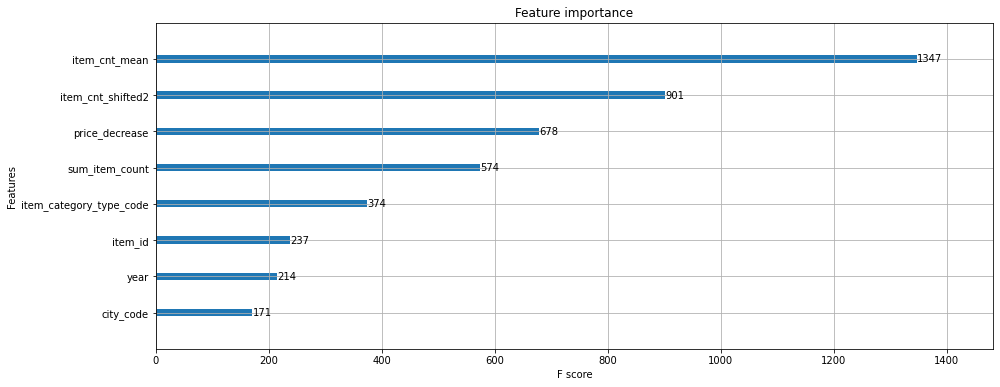

In [9]:
# Plot feature importances for model 1 
plot_features(MODEL_0, figsize=(15, 6))

It appears the most important feature by a large amount is item_cnt_mean, with a F-score of 1347. Far behind is item_cnt_shifted2 and price_decrease around 900. The least important is city_code. F-score combines precision and recall to gauge a model's overall performance. In this context, it is applied to our model's features.

Ref: https://deepai.org/machine-learning-glossary-and-terms/f-score

In [10]:
# Make predictions on train set
model_0_predictions_train = MODEL_0.predict(train_X[features_subsets[0]]).clip(0,50)

print('Model 0 train rmse:', np.sqrt(mean_squared_error(train_Y, model_0_predictions_train)))

Model 0 train rmse: 0.7659338822546984


In [11]:
# Make predictions on validation set
model_0_predictions_validation = MODEL_0.predict(validation_X[features_subsets[0]]).clip(0,50)

print('Model 0 validation rmse:', np.sqrt(mean_squared_error(validation_Y, model_0_predictions_validation)))

Model 0 validation rmse: 0.46040532943767487


Validation RMSE is lower than train RMSE, questionable. Worried we have overfit our model. However, performance for both train and validation datset are less than 1 which . Evaluate other models now.

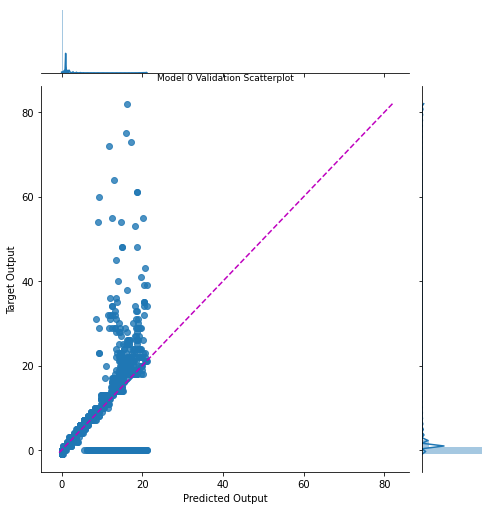

In [12]:
# Plot validation data to see performance
model_performance_sc_plot(model_0_predictions_validation, validation_Y["sum_item_cnt_next_month"], 'Model 0 Validation Scatterplot')

Seems like many points are close to linear trend, however there is a huge spike for predictions at 20. This could be something to investigate regarding our model producing lower predictions. Also, there are a line of plots with label 0 and predictions are in the range of 0 to 30. This would be something to look into.

In [13]:
# Load second model
MODEL_1 = pickle.load(open(os.path.join(model_dir, 'MODEL_1.pickle'), "rb"))

[12:30:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


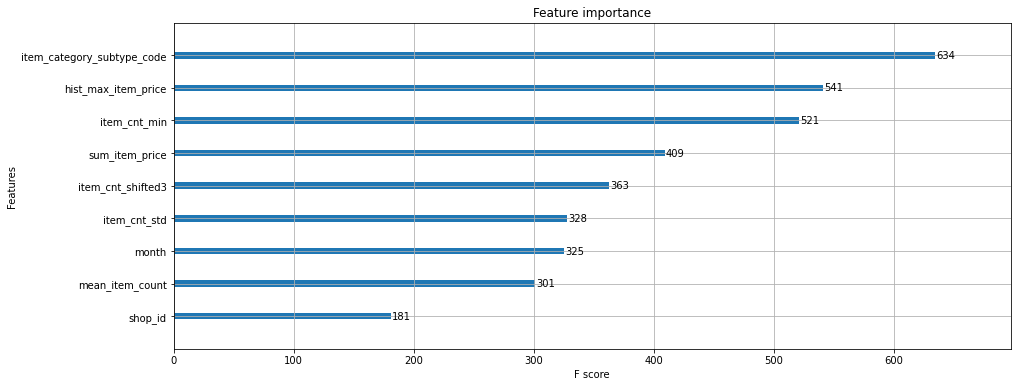

In [14]:
# Plot feature importances for second model
plot_features(MODEL_1, figsize=(15, 6))

It appears for our second model, the most important feature is item_category_subtype, with an F-score of 634. At 541 and 521 are hist_max_item_price and item_cnt_min respectivelly. The weakest feature is shop_id.

In [15]:
# Make predictions on train set
model_1_predictions_train = MODEL_1.predict(train_X[features_subsets[1]]).clip(0,50)

print('Model 1 train rmse:', np.sqrt(mean_squared_error(train_Y, model_1_predictions_train)))

Model 1 train rmse: 0.857144992920556


In [16]:
# Make predictions on validation set
model_1_predictions_validation = MODEL_1.predict(validation_X[features_subsets[1]]).clip(0,50)

print('Model 1 validation rmse:', np.sqrt(mean_squared_error(validation_Y, model_1_predictions_validation)))

Model 1 validation rmse: 0.5421107639925716


Again, for model 1, the validation RMSE is lower than our train RMSE. Our model seems optimised to perform well on our validation set, which could be a great thing. Also, the values are consistent with the first model, although slightly worse in performance with train RMSE at 0.857 and validation RMSE at 0.542. This could indicate the features used to train model 1 are less important to predict the item sales for the next month than those in model 0. This could perhaps also be inferred by the lower maximum F-score for the features in model 1.

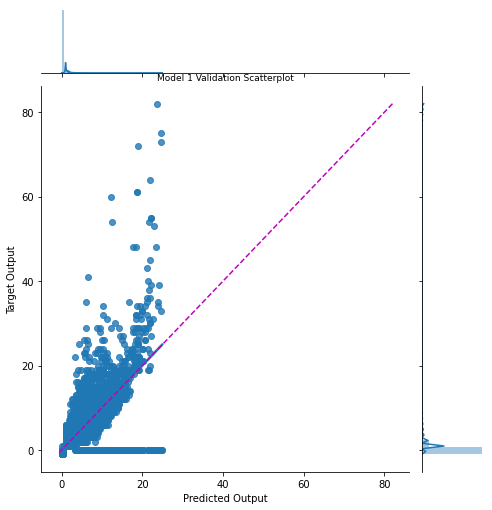

In [17]:
# Plot validattion data to see performance
model_performance_sc_plot(model_1_predictions_validation, validation_Y["sum_item_cnt_next_month"], 'Model 1 Validation Scatterplot')

Here we can see points having a larger vertical spread, than the prior validation graph and less linear correlation which is expected as this model performs worse than the first model. This time we see more dramatic rise at prediction=20, with labels going up to 80 for values.

In [18]:
# Load third model 
MODEL_2 = pickle.load(open(os.path.join(model_dir, 'MODEL_2.pickle'), "rb"))

[12:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


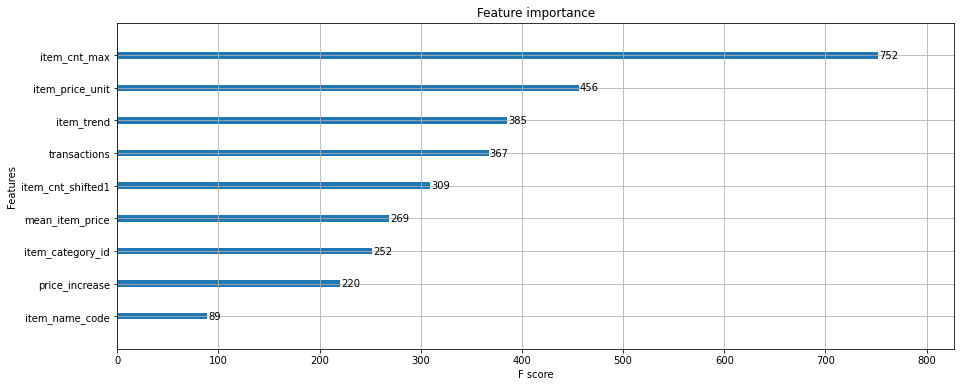

In [19]:
# Plot feature importances for model 2
plot_features(MODEL_2, figsize=(15, 6))

Most important feature is item_cnt_max with an F-score of 752, followed by item_price_unit with 456. The weakest feature is item_name_code with an F-score of 89, the lowests F-score of the three models.

In [20]:
# Make predictions on train set
model_2_predictions_train = MODEL_2.predict(train_X[features_subsets[2]]).clip(0,50)

print('Model 2 train rmse:', np.sqrt(mean_squared_error(train_Y, model_2_predictions_train)))

Model 2 train rmse: 0.8014202960858962


In [22]:
# Make predictions on validation set
model_2_predictions_validation = MODEL_2.predict(validation_X[features_subsets[2]]).clip(0,50)

print('Model 2 validation rmse:', np.sqrt(mean_squared_error(validation_Y, model_2_predictions_validation)))

Model 2 validation rmse: 0.49780744328025783


The train rmse is the second lowest of the three models with a value of 0.80. The validation rmse is also the second lowst of the three models.

In [24]:
# See all model rmse values for train and validation sets
print('Model 0 train rmse:', np.sqrt(mean_squared_error(train_Y, model_0_predictions_train)))
print('Model 1 train rmse:', np.sqrt(mean_squared_error(train_Y, model_1_predictions_train)))
print('Model 2 train rmse:', np.sqrt(mean_squared_error(train_Y, model_2_predictions_train)))
print("")
print('Model 0 validation rmse:', np.sqrt(mean_squared_error(validation_Y, model_0_predictions_validation)))
print('Model 1 validation rmse:', np.sqrt(mean_squared_error(validation_Y, model_1_predictions_validation)))
print('Model 2 validation rmse:', np.sqrt(mean_squared_error(validation_Y, model_2_predictions_validation)))

Model 0 train rmse: 0.7659338822546984
Model 1 train rmse: 0.857144992920556
Model 2 train rmse: 0.8014202960858962

Model 0 validation rmse: 0.46040532943767487
Model 1 validation rmse: 0.5421107639925716
Model 2 validation rmse: 0.49780744328025783


So we can see the best performing model is model 0 for both train and validation data, and the worst performing model is model 1. We will now stack our predicted outputs and apply linear regression. The hope is the stacked model leads to better results.

In [25]:
# Build stacked training df
stacked_train_df = pd.DataFrame(model_0_predictions_train, columns=['model_0'])
stacked_train_df['model_1'] = model_1_predictions_train
stacked_train_df['model_2'] = model_2_predictions_train
stacked_train_df['target'] = train_Y.values

stacked_train_df.head()

,model_0,model_1,model_2,target
0,1.76,1.96,1.67,2.00
1,2.79,1.78,2.67,3.00
2,1.06,1.17,1.05,1.00
3,1.02,1.17,1.03,1.00
4,1.06,1.26,0.95,1.00


In [26]:
# Build stacked validation df
stacked_validation_df = pd.DataFrame(model_0_predictions_validation, columns=['model_0'])
stacked_validation_df['model_1'] = model_1_predictions_validation
stacked_validation_df['model_2'] = model_2_predictions_validation
stacked_validation_df['target'] = validation_Y.values

stacked_validation_df.head()

,model_0,model_1,model_2,target
0,0.87,0.92,0.94,1.00
1,0.97,0.92,0.94,1.00
2,0.97,0.92,0.93,1.00
3,0.97,0.92,0.94,1.00
4,1.01,1.24,0.97,1.00


In [27]:
# For each model, make predictions on test data and build stacked test df
model_0_predictions_test = MODEL_0.predict(test_X[features_subsets[0]]).clip(0,50)
model_1_predictions_test = MODEL_1.predict(test_X[features_subsets[1]]).clip(0,50)
model_2_predictions_test = MODEL_2.predict(test_X[features_subsets[2]]).clip(0,50)

# Build stacked test df
stacked_test_df = pd.DataFrame(model_0_predictions_test, columns=['model_0'])
stacked_test_df['model_1'] = model_1_predictions_test
stacked_test_df['model_2'] = model_2_predictions_test

stacked_test_df.head()

,model_0,model_1,model_2
0,0.03,0.09,0.06
1,0.03,0.09,0.06
2,1.05,1.39,1.13
3,0.03,0.09,0.06
4,0.03,0.09,0.06


Great! We are all set for training our linear regression model. Whilst a more complicated model can be applied, we have opted for a simple model as we only have 3 features which are numerical in value. An option is to play around with the type of model and generally experiment with the possibilities.

Our training approach here will be to first fit a linear regression to train data predictions from our first layer of models, then further fit the linear regression model with the validation data predictions from our first layer of models. This may be considered a very basic form of fine-tuning and hoping to squeeze better performance for ultimately making predictions on our test set.

In [0]:
# Import libraries for linear regression
from sklearn.linear_model import LinearRegression

# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [0]:
# Initialise LinearRegression model, use all processors available.
stacked_model = LinearRegression(n_jobs=-1) 

In [31]:
stacked_train_df.columns

Index(['model_0', 'model_1', 'model_2', 'target'], dtype='object')

In [0]:
# Get training and test features for our training set
stacked_train_df_X = stacked_train_df[['model_0', 'model_1', 'model_2']]
stacked_train_df_Y = stacked_train_df.target

# As well as our validation set
stacked_validation_df_X = stacked_validation_df[['model_0', 'model_1', 'model_2']]
stacked_validation_df_Y = stacked_validation_df.target

In [37]:
stacked_train_df_X.head(), stacked_train_df_Y.head()

(   model_0  model_1  model_2
 0     1.76     1.96     1.67
 1     2.79     1.78     2.67
 2     1.06     1.17     1.05
 3     1.02     1.17     1.03
 4     1.06     1.26     0.95, 0   2.00
 1   3.00
 2   1.00
 3   1.00
 4   1.00
 Name: target, dtype: float64)

In [38]:
stacked_validation_df_X.head(), stacked_validation_df_Y.head()

(   model_0  model_1  model_2
 0     0.87     0.92     0.94
 1     0.97     0.92     0.94
 2     0.97     0.92     0.93
 3     0.97     0.92     0.94
 4     1.01     1.24     0.97, 0   1.00
 1   1.00
 2   1.00
 3   1.00
 4   1.00
 Name: target, dtype: float64)

In [35]:
# Fit linear regression to outputs of XGBoost on train predictions
stacked_model.fit(stacked_train_df_X, stacked_train_df_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [43]:
# See how model performs on train and val data
stacked_model_train_pred = stacked_model.predict(stacked_train_df_X)
stacked_model_validation_pred =stacked_model.predict(stacked_validation_df_X) 

print('Linear model trained on train outputs from first layer models.')
print('Train rmse:', np.sqrt(mean_squared_error(stacked_model_train_pred, stacked_train_df_Y)))
print('Validation rmse:', np.sqrt(mean_squared_error(stacked_model_validation_pred, stacked_validation_df_Y)))

Linear model trained on train outputs from first layer models.
Train rmse: 0.7609417347558269
Validation rmse: 0.4674036923399024


The train performance is better than all of the initial models. Validation performance is 0.007 rmse value greater than the best xgboost model (model 1). This shows promise for a stacked model.

In [44]:
# Now further fit on validation outputs of XGBoost (fine-tune)
stacked_model.fit(stacked_validation_df_X, stacked_validation_df_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [45]:
# And again, assess performance
stacked_model_train_pred = stacked_model.predict(stacked_train_df_X)
stacked_model_validation_pred =stacked_model.predict(stacked_validation_df_X) 

print('Linear model trained on train outputs from first layer models.')
print('Train rmse:', np.sqrt(mean_squared_error(stacked_model_train_pred, stacked_train_df_Y)))
print('Validation rmse:', np.sqrt(mean_squared_error(stacked_model_validation_pred, stacked_validation_df_Y)))

Linear model trained on train outputs from first layer models.
Train rmse: 0.7667652457410442
Validation rmse: 0.45888806686050015


Great! The validation rmse went down to 0.4588 and outperforms first layer models. The train rmse increased slightly as expected. Another thing to try is perhaps train a linear model only on the validation outputs. However, moving forward, we will make predictions for our test set and create a submission file.

In [53]:
# Make predicitons on test set
stacked_model_test_pred = stacked_model.predict(stacked_test_df).clip(0, 50)

min(stacked_model_test_pred), max(stacked_model_test_pred), len(stacked_model_test_pred)

(0.0, 22.58459, 214200)

In [0]:
# Load the template, set predictions and save!
submission_test = pd.read_csv(os.path.join('./data/competition_files/sample_submission.csv'), index_col='ID')
submission_test['item_cnt_month'] = stacked_model_test_pred
pd.DataFrame(submission_test).to_csv(os.path.join(data_dir, 'submission.csv'), header=True, index=True)